Motivation: Make networks deeper without huge parameter growth.

Used Inception modules (parallel convs of different sizes).

Limitation: Complex design, handcrafted modules.

the naming of **InceptionNet** (a.k.a. GoogLeNet) actually has a fun story.

---

### 🔹 Why "Inception"?

* In 2010, the movie **Inception** (directed by Christopher Nolan) came out, famous for the line: *“We need to go deeper.”*
* The GoogLeNet team (Szegedy et al., 2014) was building a very **deep network**, much deeper than AlexNet and VGG.
* So they named their architecture **Inception** as a playful reference to that movie quote.

---

### 🔹 Why GoogLeNet (with an extra "o")?

* It was also a tribute to **LeNet-5** (the CNN by Yann LeCun in the 1990s).
* Since the team was from Google, they called it **GoogLeNet** (instead of InceptionNet) to echo LeNet while branding it.
* That’s why in papers, you’ll often see *“Inception (GoogLeNet)”*.

---

✅ So:

* **“Inception”** → from the movie, hinting at *going deeper*.
* **“GoogLeNet”** → homage to LeNet, with Google’s twist.

---

Do you also want me to explain how the **Inception module itself** embodies the idea of “inception” (multiple scales nested inside one block — like a network within a network)? That’s another neat angle.


In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score

In [2]:
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_WORKERS = 4
best_val_loss = 1e9

In [3]:
train_dataset = datasets.CIFAR10(root='../data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='../data', 
                                train=False,
                                transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

Files already downloaded and verified


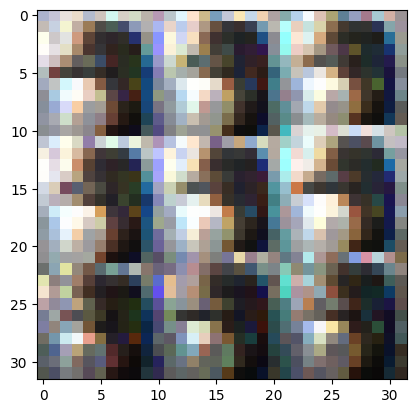

In [4]:
img = next(iter(train_loader))
plt.imshow(img[0][1].reshape(32,32,3))

In [5]:
majority_prediction = torch.argmax(torch.bincount(all_test_labels))
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.00%


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [7]:
device

'cpu'

In [89]:
# Let's Go Deeper!

import torch
from torch import nn
import torch.nn.functional as F


# Convolution -> Batch Norm -> Relu
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=.001)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bn(self.conv(x))
        return F.relu(x, inplace=True)
    
class ShapePrinter(nn.Module):
    def __init__(self, name=""):
        super().__init__()
        self.name = name

    def forward(self, x):
        print(f"{self.name}: {x.shape}")
        return x


class InceptionBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_1x1,
        outinception_3x3_reduced,
        outinception_3x3,
        outinception_5x5_reduced,
        outinception_5x5,
        out_pool
    ):
        super().__init__()

        self.branch1 = ConvBlock(
            in_channels, out_1x1, kernel_size=1, stride=1
        )

        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, outinception_3x3_reduced, kernel_size=1),
            ConvBlock(outinception_3x3_reduced, outinception_3x3, kernel_size=3, padding=1),
        )

        # Is in the original googLeNet paper 5x5 conv but in Inception_v2 it has shown to be
        # more efficient if you instead do two 3x3 convs which is what I am doing here!
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, outinception_5x5_reduced, kernel_size=1),
            ConvBlock(outinception_5x5_reduced, outinception_5x5, kernel_size=5, padding=2),
            ConvBlock(outinception_5x5, outinception_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        y1 = self.branch1(x)
        print("=====\n")
        y2 = self.branch2(x)
        print("=====\n")
        y3 = self.branch3(x)
        print("=====\n")
        y4 = self.branch4(x)
        print("=====\n")

        return torch.cat([y1, y2, y3, y4], 1)


class Inception(nn.Module):
    def __init__(self, num_classes, grayscale=False):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.first_layers = nn.Sequential(
            ConvBlock(in_channels, 192, kernel_size=3, padding=1)
        )

        self.inception_3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

        self.inception_5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out: torch.Tensor
        out = self.first_layers(x)

        out = self.inception_3a(out)
        out = self.inception_3b(out)
        out = self.max_pool(out)

        out = self.inception_4a(out)
        out = self.inception_4b(out)
        out = self.inception_4c(out)
        out = self.inception_4d(out)
        out = self.inception_4e(out)
        out = self.max_pool(out)

        out = self.inception_5a(out)
        out = self.inception_5b(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        return self.fc(out)

#### Shape testing

In [93]:
def attach_shape_hooks(model):
    """
    Attaches forward hooks to all layers of a model 
    to print input/output shapes during a forward pass.
    """
    def hook(module, inp, out):
        # skip printing for containers (Sequential, ModuleList etc.)
        if not isinstance(module, (nn.Sequential, nn.ModuleList)):
            print(f"{module.__class__.__name__:<20} "
                  f"input: {tuple(inp[0].shape)} "
                  f"output: {tuple(out.shape)}")

    hooks = []
    for layer in model.modules():
        hooks.append(layer.register_forward_hook(hook))
    return hooks

In [90]:
test = nn.Sequential(ConvBlock(3, 192, kernel_size=3, padding=1))(img[0])

In [91]:
test.shape

torch.Size([64, 192, 32, 32])

In [92]:
inc = InceptionBlock(192, 66, 96, 126, 14, 30, 30)

In [94]:
hooks = attach_shape_hooks(inc)

In [95]:
oo = inc(test)

Conv2d               input: (64, 192, 32, 32) output: (64, 66, 32, 32)
BatchNorm2d          input: (64, 66, 32, 32) output: (64, 66, 32, 32)
ConvBlock            input: (64, 192, 32, 32) output: (64, 66, 32, 32)
=====

Conv2d               input: (64, 192, 32, 32) output: (64, 96, 32, 32)
BatchNorm2d          input: (64, 96, 32, 32) output: (64, 96, 32, 32)
ConvBlock            input: (64, 192, 32, 32) output: (64, 96, 32, 32)
Conv2d               input: (64, 96, 32, 32) output: (64, 126, 32, 32)
BatchNorm2d          input: (64, 126, 32, 32) output: (64, 126, 32, 32)
ConvBlock            input: (64, 96, 32, 32) output: (64, 126, 32, 32)
=====

Conv2d               input: (64, 192, 32, 32) output: (64, 14, 32, 32)
BatchNorm2d          input: (64, 14, 32, 32) output: (64, 14, 32, 32)
ConvBlock            input: (64, 192, 32, 32) output: (64, 14, 32, 32)
Conv2d               input: (64, 14, 32, 32) output: (64, 30, 32, 32)
BatchNorm2d          input: (64, 30, 32, 32) output: (64, 30, 32, 

In [44]:
128+32+32+64

256

In [36]:
for h in hooks:
    h.remove()

#### ----------------------------------------------------------------------------------

In [17]:
model = Inception(num_classes=10)
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

6.158346 M parameters


In [10]:
for ep in range(NUM_EPOCHS):
    all_pred_labels = []
    trl = 0
    m.train()
    for x_b, y_b in train_loader:
        x_b = x_b.to(device)
        y_b = y_b.to(device)
        logits = m(x_b)
        loss = F.cross_entropy(logits, y_b)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        trl += loss.item()
    
    m.eval()
    with torch.no_grad():
        vdl = 0
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            loss = F.cross_entropy(logits, y_v_b)
            vdl += loss.item()
        print(f'epoch {ep} | train_loss: {trl/len(train_loader):.4f} valid_loss: {vdl/len(test_loader):.4f}')
    
    if vdl < best_val_loss:
        best_val_loss = vdl
        for x_v_b, y_v_b in test_loader:
            x_v_b, y_v_b = x_v_b.to(device), y_v_b.to(device)
            logits = m(x_v_b)
            pred_label = F.softmax(logits,dim=-1).argmax(dim=-1)
            all_pred_labels.extend(list(pred_label.detach().cpu().flatten().numpy()))
        print("Accuracy: ",accuracy_score(all_test_labels.detach().cpu().flatten().numpy(), all_pred_labels))

epoch 0 | train_loss: 1.2482 valid_loss: 1.2768
Accuracy:  0.5736
epoch 1 | train_loss: 0.7794 valid_loss: 0.7304
Accuracy:  0.7439
epoch 2 | train_loss: 0.6000 valid_loss: 0.6109
Accuracy:  0.7889
epoch 3 | train_loss: 0.4898 valid_loss: 0.5428
Accuracy:  0.811
epoch 4 | train_loss: 0.4093 valid_loss: 0.6806
epoch 5 | train_loss: 0.3458 valid_loss: 0.5063
Accuracy:  0.8336
epoch 6 | train_loss: 0.2943 valid_loss: 0.4786
Accuracy:  0.8443
epoch 7 | train_loss: 0.2503 valid_loss: 0.5122


KeyboardInterrupt: 